[INFO] Memulai Training Master Augmentor...
Epoch 0 | Loss G: 0.0823 | Phys Penalty: 2.8421
Epoch 200 | Loss G: -148.4106 | Phys Penalty: 0.1854
Epoch 400 | Loss G: -210.4299 | Phys Penalty: 0.1911
Epoch 600 | Loss G: -420.7935 | Phys Penalty: 0.1359
Epoch 800 | Loss G: -697.7703 | Phys Penalty: 0.3493
Epoch 1000 | Loss G: -1034.2625 | Phys Penalty: 0.1096
Epoch 1200 | Loss G: -1418.6160 | Phys Penalty: 0.5257
Epoch 1400 | Loss G: -1921.7395 | Phys Penalty: 0.7491
[SUCCESS] Dataset Skenario Selesai: 5400 baris, 37 kolom.
[INFO] Menjalankan Validasi Visual...


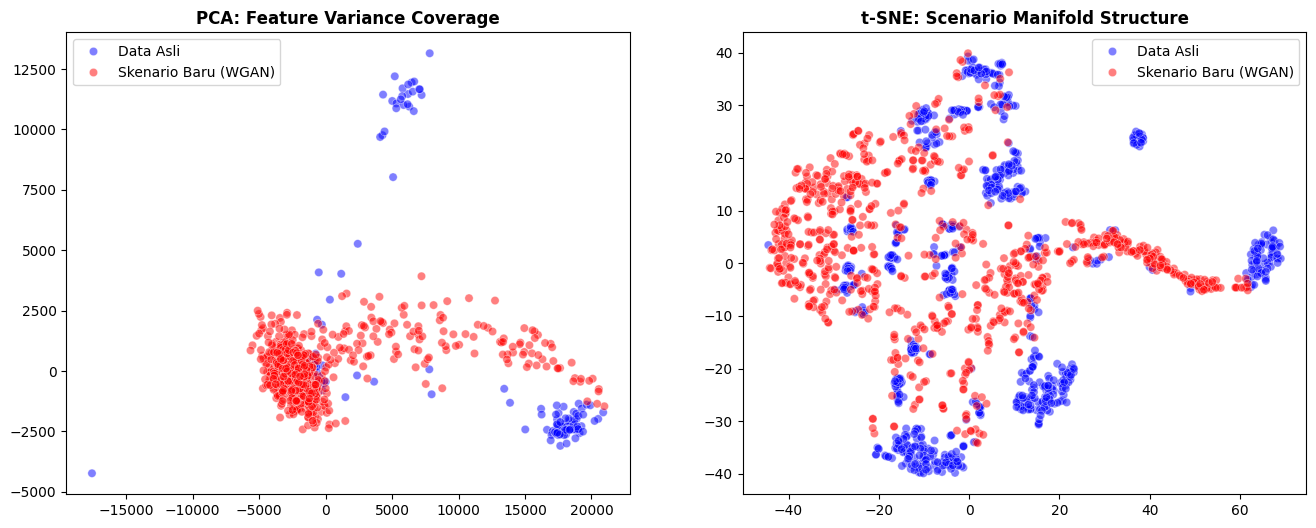

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import io
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ==========================================
# 1. KONFIGURASI & PATH
# ==========================================
MODEL_PATH = "wgan_master_v3.pth"
SCALER_PATH = "scaler_master_v3.pkl"
DATA_INPUT = "dataset_dqn_rich.csv"
OUTPUT_CSV = "augmented_scenario_dataset.csv"

# Hyperparameters
LATENT_DIM = 128
CONDITION_DIM = 27  # 3^3 Kombinasi (P1, P2, P4) x (Normal, Overload, Burst)
EPOCHS = 1500
BATCH_SIZE = 64

# ==========================================
# 2. LOAD & PREPARE DATA
# ==========================================
def load_and_clean(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip().strip('"') for line in f if line.strip()]
    df = pd.read_csv(io.StringIO("\n".join(lines)), sep=';', decimal=',')
    feature_names = [col for col in df.columns if col != 'timestamp']
    return df, feature_names

df_real, feature_names = load_and_clean(DATA_INPUT)

# ==========================================
# 3. PHYSICAL INVARIANTS LOSS (Network Logic)
# ==========================================
def network_physical_loss(gen_data, feature_list):
    """
    Memastikan AI tidak melanggar hukum fisika jaringan.
    """
    loss = 0.0
    
    # Mapping Index (Asumsi urutan 12 fitur per port)
    # P1: 0-11, P2: 12-23, P4: 24-35
    for port_offset in [0, 12, 24]:
        mbps = gen_data[:, port_offset + 0]
        pps = gen_data[:, port_offset + 2]
        util = gen_data[:, port_offset + 5]
        drop = gen_data[:, port_offset + 6]
        delay = gen_data[:, port_offset + 7]

        # Rule 1: Mbps & PPS harus berkorelasi positif
        # Jika Mbps naik, PPS harus ikut naik
        loss += torch.mean(torch.abs(mbps - pps)) * 0.5

        # Rule 2: Packet Drop hanya boleh ada jika Util > 0.8 (Normalisai space)
        # Jika util rendah (misal < 0.8), hukun jika ada drop > 0
        low_util_mask = (util < 0.8).float()
        loss += torch.mean(torch.relu(drop) * low_util_mask) * 10.0

        # Rule 3: Delay wajib naik jika Util mendekati 1.0 (Congestion)
        # Hukum jika util tinggi tapi delay tetap rendah
        high_util_mask = (util > 0.9).float()
        loss += torch.mean(torch.relu(0.8 - delay) * high_util_mask) * 5.0

    return loss

# ==========================================
# 4. MODEL ARCHITECTURE
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim, cond_dim, out_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, out_dim),
            nn.Tanh()
        )
    def forward(self, z, c):
        return self.main(torch.cat([z, c], dim=1))

class Critic(nn.Module):
    def __init__(self, in_dim, cond_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_dim + cond_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x, c):
        return self.main(torch.cat([x, c], dim=1))

# ==========================================
# 5. TRAINING WITH SEMANTIC GUIDANCE
# ==========================================
def train_master_wgan(df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dim = len(feature_names)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(df[feature_names])
    
    gen = Generator(LATENT_DIM, CONDITION_DIM, out_dim).to(device)
    crit = Critic(out_dim, CONDITION_DIM).to(device)

    if os.path.exists(MODEL_PATH):
        print("[INFO] Checkpoint ditemukan. Loading...")
        gen.load_state_dict(torch.load(MODEL_PATH))
        return gen, scaler, device

    opt_G = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
    opt_C = optim.Adam(crit.parameters(), lr=1e-4, betas=(0.5, 0.9))
    
    data_tensor = torch.FloatTensor(data_scaled).to(device)

    print("[INFO] Memulai Training Master Augmentor...")
    for epoch in range(EPOCHS + 1):
        # 1. Train Critic
        for _ in range(5):
            idx = np.random.randint(0, data_tensor.size(0), BATCH_SIZE)
            real_batch = data_tensor[idx]
            z = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
            # Create random scenario labels (27 combinations)
            labels = torch.eye(CONDITION_DIM)[np.random.choice(CONDITION_DIM, BATCH_SIZE)].to(device)
            
            fake_batch = gen(z, labels)
            loss_C = -torch.mean(crit(real_batch, labels)) + torch.mean(crit(fake_batch.detach(), labels))
            
            opt_C.zero_grad(); loss_C.backward(); opt_C.step()

        # 2. Train Generator (With Physical Loss)
        z = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
        labels = torch.eye(CONDITION_DIM)[np.random.choice(CONDITION_DIM, BATCH_SIZE)].to(device)
        gen_data = gen(z, labels)
        
        # WGAN Loss + Physical Penalty
        loss_G = -torch.mean(crit(gen_data, labels))
        loss_phys = network_physical_loss(gen_data, feature_names)
        
        total_G_loss = loss_G + (loss_phys * 20.0) # Penalti fisik diperkuat

        opt_G.zero_grad(); total_G_loss.backward(); opt_G.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch} | Loss G: {loss_G.item():.4f} | Phys Penalty: {loss_phys.item():.4f}")

    torch.save(gen.state_dict(), MODEL_PATH)
    joblib.dump(scaler, SCALER_PATH)
    return gen, scaler, device

# ==========================================
# 6. SCENARIO GENERATION (27 COMBINATIONS)
# ==========================================
def generate_all_scenarios(gen, scaler, num_per_scenario=200):
    gen.eval()
    all_data = []
    
    # 27 Kombinasi: 3 Port ^ 3 Kondisi (Normal, Overload, Burst)
    for scenario_id in range(CONDITION_DIM):
        z = torch.randn(num_per_scenario, LATENT_DIM).to(dev)
        label = torch.zeros(num_per_scenario, CONDITION_DIM).to(dev)
        label[:, scenario_id] = 1.0
        
        with torch.no_grad():
            samples = gen(z, label).cpu().numpy()
            all_data.append(scaler.inverse_transform(samples))
    
    # Gabungkan semua skenario
    combined_data = np.vstack(all_data)
    df_aug = pd.DataFrame(combined_data, columns=feature_names)
    
    # Fix Timestamps
    last_ts = pd.to_datetime(df_real['timestamp'].iloc[-1])
    df_aug['timestamp'] = [(last_ts + pd.Timedelta(seconds=i+1)).strftime("%Y-%m-%dT%H:%M:%SZ") for i in range(len(df_aug))]
    
    df_aug = df_aug[['timestamp'] + feature_names]
    df_aug.to_csv(OUTPUT_CSV, index=False, sep=';', decimal=',')
    print(f"[SUCCESS] Dataset Skenario Selesai: {len(df_aug)} baris, 37 kolom.")
    return df_aug

# ==========================================
# 7. EVALUASI VISUAL
# ==========================================
def plot_master_evaluation(real, fake):
    print("[INFO] Menjalankan Validasi Visual...")
    n = 800
    r_sample = real[feature_names].sample(n).values
    f_sample = fake[feature_names].sample(n).values
    
    combined = np.vstack([r_sample, f_sample])
    labels = ['Data Asli']*n + ['Skenario Baru (WGAN)']*n
    
    pca = PCA(n_components=2).fit_transform(combined)
    tsne = TSNE(n_components=2, perplexity=30).fit_transform(combined)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=labels, ax=ax1, palette=['blue', 'red'], alpha=0.5)
    ax1.set_title("PCA: Feature Variance Coverage", fontweight='bold')
    
    sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=labels, ax=ax2, palette=['blue', 'red'], alpha=0.5)
    ax2.set_title("t-SNE: Scenario Manifold Structure", fontweight='bold')
    
    plt.savefig("master_visual_evaluation.png", dpi=300)
    plt.show()

# --- EKSEKUSI ---
model_gen, master_scaler, dev = train_master_wgan(df_real)
df_augmented_final = generate_all_scenarios(model_gen, master_scaler)
plot_master_evaluation(df_real, df_augmented_final)